# Gaussian Mixture Models

The *k-means* clustering model explored int he previous section is simple and relatively easy to understand, but its simplicity leads to practical callenges in its application. In particular, the non-probabilistic nature of *k-means* and its use of simple distance-from cluster-center to assign cluster membership leads to ppor performance ofr many real-world situations. In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behidn *k-means*, bu can also be a poweful tool for estimation beyond simple clustering.

We begin with the standard imports:

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of k-Means

Let's take a look at some of the weaknesses of *k-means* and think about how we might imporve the cluster model. As we saw in the prevoius section, given simple, well-separated data, *k-means* finds suitable clustering results.

For example, if we have simple blobs of data, the *k-means* algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [3]:
# generate some data

from sklearn.datasets._samples_generator import make_blobs 

X, y_true = make_blobs(n_samples=400, centers=4,
                        cluster_std=0.60, random_state=0)

X = X[:, ::-1] # flip axes for better plotting

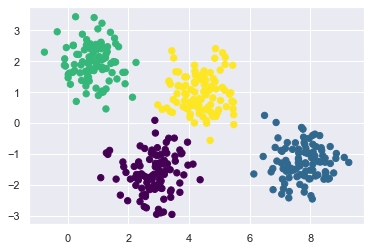

In [4]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans 

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete condifence in the cluster assignment of points between them.

Unfortunately, the *k-means* model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a boostrap approach to estimate this uncertainty). For this, we must think about generalizing the model.

One way to think about hte *k-means* model is that it places a circle (or, in higher dimensions, a hyper-shpere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside thir circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

In [20]:
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist 

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the represetnation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
            for i, center in enumerate(centers)]

    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))            

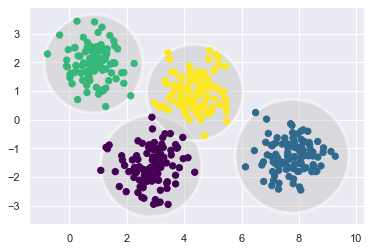

In [21]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for *kmeans* is that these cluster models *must be circular*: *kmeans* has no built-in way of accounting for oblong or elliptical lusters. So, for example, if we take the same data nd transform it, the cluster assignments end up becoming muddled:

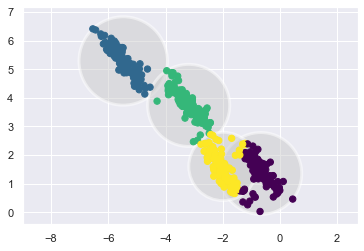

In [22]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize htat hese transformed clusters are non-circular, and thus ciruclar clusters would be a poor fit. Nevertheless, *k-means* is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This resutls in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot. One might imagine addressing this particular situation by preprocessing the data with PCA, but in practice there is no guarantee that such a blogal operation will circularice the individual data.

These two disadvanteges of *k-means* its lack of flexibility in cluster shape and lack of probabilistic cluster assignment mean that for many datasets (specially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the *k-means* model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point *all* cluster centers, rather than focusing on just the closest. You might also imagine allowing the cluster boudnaries to be ellipses rather than circles, so as the accoount for non-circular clusters. It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.